# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
## import train test split
from sklearn.model_selection import train_test_split, GridSearchCV

## transform column
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

## mising value treatment
from sklearn.impute import SimpleImputer

## import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

## import  tree model
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## import non-tree model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Read file

### Loading data

In [2]:
df = pd.read_csv('.\data\data.csv')
data = df.copy()

# Train Test Split

In [3]:
le = LabelEncoder()
X = data.drop(columns="default", axis = 1)
Y= le.fit_transform(data["default"])

In [4]:
# Splitting data into training, validation and test set:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(700, 16) (300, 16)


### Creating dummy variables for categorical columns

In [5]:
transformer = ColumnTransformer(transformers=[
    ("tf1",OrdinalEncoder() , ['checking_balance', 'credit_history', 'savings_balance', 'employment_duration', ]),
    ("tf2", OneHotEncoder(sparse_output=False, drop='first'), ['purpose', 'other_credit','housing', 'job', 'phone' ])
], remainder='passthrough')
transformer.set_output()

ColumnTransformer(remainder='passthrough',
                  transformers=[('tf1', OrdinalEncoder(),
                                 ['checking_balance', 'credit_history',
                                  'savings_balance', 'employment_duration']),
                                ('tf2',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['purpose', 'other_credit', 'housing', 'job',
                                  'phone'])])

In [6]:
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('tf1', OrdinalEncoder(),
                                 ['checking_balance', 'credit_history',
                                  'savings_balance', 'employment_duration']),
                                ('tf2',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['purpose', 'other_credit', 'housing', 'job',
                                  'phone'])])

In [7]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
print(X_train.shape, X_test.shape)

(700, 23) (300, 23)


### Missing-Value Treatment

In [8]:
imputer = SimpleImputer(strategy= 'median')
impute = imputer.fit(X_train)
X_train = impute.transform(X_train)
X_test = imputer.transform(X_test)

### Scale data for non-tree based models

In [9]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Buidling the models

### 1. building tree base model

In [10]:
def ROC_score(model, X_test, y_test):
    # Predict probabilities for the positive class
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):  # For SVM and other models without predict_proba
        proba = model.decision_function(X_test)
        # If decision_function output is not calibrated to [0, 1], use the following:
        # from sklearn.preprocessing import MinMaxScaler
        # proba = MinMaxScaler().fit_transform(proba.reshape(-1, 1)).ravel()
    else:
        raise RuntimeError(f"The model {model_name} does not support probability predictions.")
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, proba)
    # Compute ROC curve and ROC area
    fpr_, tpr_, _ = roc_curve(y_test, proba)
    roc_auc_ = auc(fpr_, tpr_)
    return roc_auc, fpr_, tpr_, roc_auc_

In [11]:
def model_base_result(tree_models, X_train, y_train, X_test, y_test):
    train_score = []
    names = []
    test_score = []
    best_estimators = {}
    roc_auc = []
    ## define dict for roc_auc curve
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}
    for name, model, params in tree_models:
        print(f"Training and tuning {name}...")
        clf = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train, y_train)
        # Evaluate on the validation set
        val_score = clf.score(X_test, y_test)
        train_score.append(clf.best_score_)
        test_score.append(val_score)
        names.append(name)
        best_estimators[name] = clf.best_estimator_
        roc_auc_sc, fpr_, tpr_, roc_auc_ = ROC_score(clf.best_estimator_, X_test, y_test)
        roc_auc.append(roc_auc_sc)
        # Compute ROC curve and ROC area
        fpr_dict[name] = fpr_
        tpr_dict[name] = tpr_
        roc_auc_dict[name] = roc_auc_
        
    ## voting
    print("Validation accuracy for Voting Classifier...")
    # Create a list of tuples with the best estimators for the Voting Classifier
    voting_estimators = [(name, estimator) for name, estimator in best_estimators.items()]
    # Create a Voting Classifier with soft voting
    voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')
    voting_clf.fit(X_train, y_train)
    
    # Evaluate the Voting Classifier on the validation set
    voting_val_score = voting_clf.score(X_test, y_test)
    
    print("Combining result....")
    ## append all result 
    train_score.append(voting_clf.score(X_train, y_train))
    test_score.append(voting_val_score)
    names.append("Voting")
    ## ROC for voting
    roc_auc_sc, fpr_, tpr_, roc_auc_ = ROC_score(voting_clf, X_test, y_test)
    roc_auc.append(roc_auc_sc)
    ## ROC_AUC curve
    # Compute ROC curve and ROC area
    fpr_dict["Voting"] = fpr_
    tpr_dict["Voting"] = tpr_
    roc_auc_dict["Voting"] = roc_auc_
    
    result = pd.DataFrame([train_score, test_score, roc_auc], columns=names, index=["train", "test", "ROC_AUC"])
    return result, fpr_dict, tpr_dict, roc_auc_dict

In [12]:
tree_models = []
# Append tree base model
tree_models.append(('Bagging', BaggingClassifier(random_state=1), 
                    {'n_estimators': [10, 50, 100]}))
tree_models.append(('RandomForest', RandomForestClassifier(random_state=1), 
                    {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}))
tree_models.append(('GradientBoosting', GradientBoostingClassifier(random_state=1),
                    {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}))
tree_models.append(('AdaBoost', AdaBoostClassifier(random_state=1), 
                    {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}))
tree_models.append(('XGB', XGBClassifier(random_state=1), 
                    {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}))
tree_models.append(('LGBM', LGBMClassifier(random_state=1,force_row_wise=True, min_data_in_leaf=40, max_depth=-1, min_gain_to_split=0.001), {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, -1],
    'min_data_in_leaf': [20, 30, 40],
}))
tree_models.append(('CatBoost', CatBoostClassifier(random_state=1,verbose=0), 
                    {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [3, 5]}))


tree_result, fpr_dict, tpr_dict, roc_auc_dict = model_base_result(tree_models, X_train,  y_train,X_test, y_test)

Training and tuning Bagging...
Training and tuning RandomForest...
Training and tuning GradientBoosting...
Training and tuning AdaBoost...
Training and tuning XGB...
Training and tuning LGBM...
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training fr

### 2. Building non_tree base model

In [13]:
non_tree_models = []
non_tree_models.append(('LogisticRegression', LogisticRegression(random_state=1), {'C': [0.1, 1, 10]}))
non_tree_models.append(('KNN', KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}))
non_tree_models.append(('LDA', LinearDiscriminantAnalysis(), {'solver': ['svd', 'lsqr', 'eigen']}))
non_tree_models.append(('QDA', QuadraticDiscriminantAnalysis(), {}))
non_tree_models.append(('SVM', SVC(probability=True,random_state=1), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}))  

In [14]:
non_tree_result, non_fpr_dict, non_tpr_dict, non_roc_auc_dict = model_base_result(non_tree_models, X_train_scaled, y_train, X_test_scaled, y_test)

Training and tuning LogisticRegression...
Training and tuning KNN...
Training and tuning LDA...
Training and tuning QDA...
Training and tuning SVM...
Validation accuracy for Voting Classifier...
Combining result....


### 3. Save result to table for report later

In [15]:
def save_data(non_tree_result, tree_result):
    non_tree_result_x = non_tree_result.T
    non_tree_result_x['model_type'] = "non_tree_base_model"
    non_tree_result_x['model'] = non_tree_result_x.index

    tree_result_x = tree_result.T
    tree_result_x['model_type'] = "tree_base_model"
    tree_result_x['model'] = tree_result_x.index
    
    result = pd.concat([non_tree_result_x.reset_index(drop=True),tree_result_x.reset_index(drop= True)], axis=0 )
    sort_col = ['model_type', 'model', 'train', 'test', 'ROC_AUC']
    result[sort_col].to_csv(r'.\data\model_comparison.csv', index = False)
    return result[sort_col]
result = save_data(non_tree_result, tree_result)

# Result visualization

### Tree vs non_tree based model

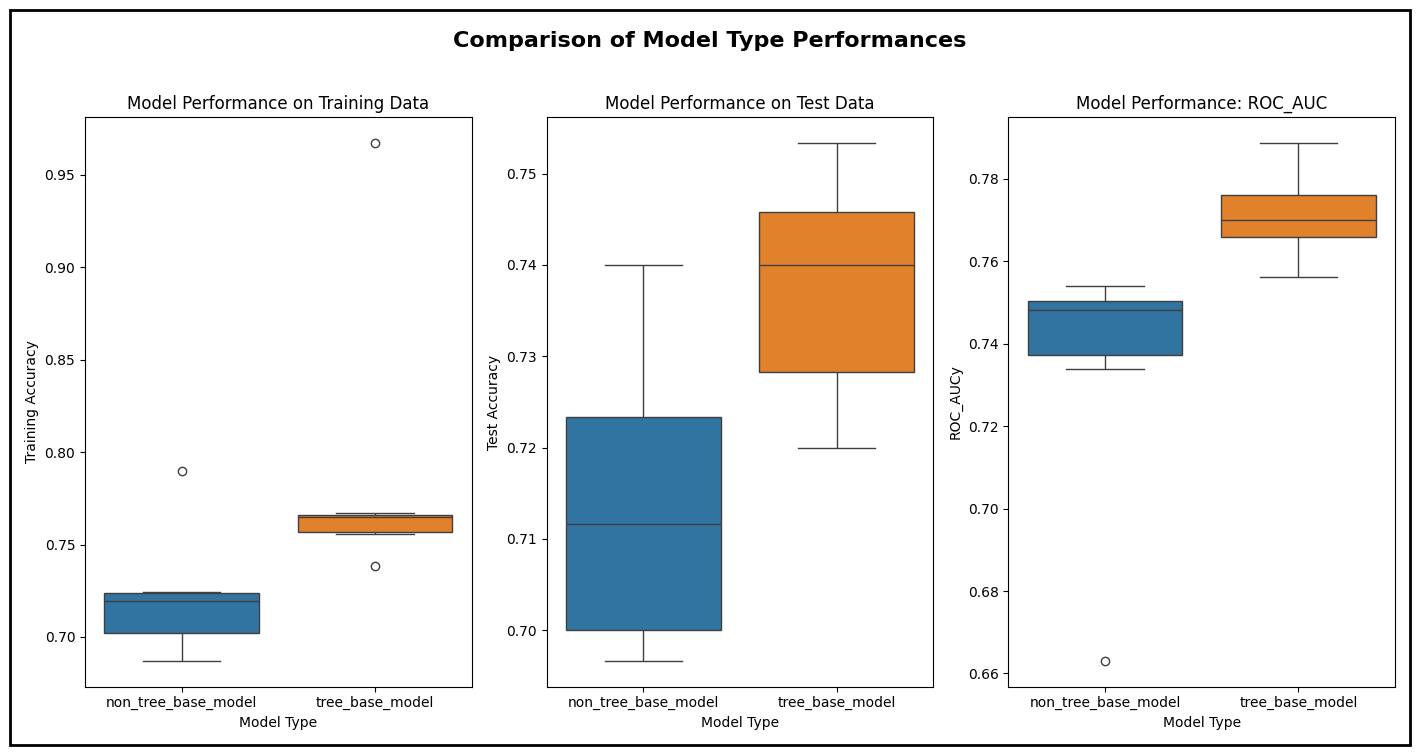

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))
# Plot for training data
sns.boxplot(data=result, x='model_type', y='train', hue='model_type', ax=ax[0])
ax[0].set_title('Model Performance on Training Data')  # Set title for the left subplot
ax[0].set_xlabel('Model Type')  # Set x-axis label
ax[0].set_ylabel('Training Accuracy')  # Set y-axis label
ax[0].legend(title='Model Type')  # Set legend title
ax[0].get_legend().remove()  # Optional: remove the legend if it's redundant
# Plot for test data
sns.boxplot(data=result, x='model_type', y='test', hue='model_type', ax=ax[1])
ax[1].set_title('Model Performance on Test Data')  # Set title for the right subplot
ax[1].set_xlabel('Model Type')  # Set x-axis label
ax[1].set_ylabel('Test Accuracy')  # Set y-axis label
ax[1].legend(title='Model Type')  # Set legend title
ax[1].get_legend().remove()  # Optional: remove the legend if it's redundant
# Plot for ROC data
sns.boxplot(data=result, x='model_type', y='ROC_AUC', hue='model_type', ax=ax[2])
ax[2].set_title('Model Performance: ROC_AUC')  # Set title for the right subplot
ax[2].set_xlabel('Model Type')  # Set x-axis label
ax[2].set_ylabel('ROC_AUCy')  # Set y-axis label
ax[2].legend(title='Model Type')  # Set legend title
ax[2].get_legend().remove()  # Optional: remove the legend if it's redundant

# Add a figure title
fig.suptitle('Comparison of Model Type Performances', fontsize=16, y=1.02, fontweight = "bold")
plt.tight_layout()
rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.00, 0.0), 1, 1.05, fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
# Add the rectangle to the figure
fig.patches.extend([rect])
plt.tight_layout()
plt.show()
fig.savefig(r'.\data\model_type_performance.png', bbox_inches="tight")

### model compare within model type

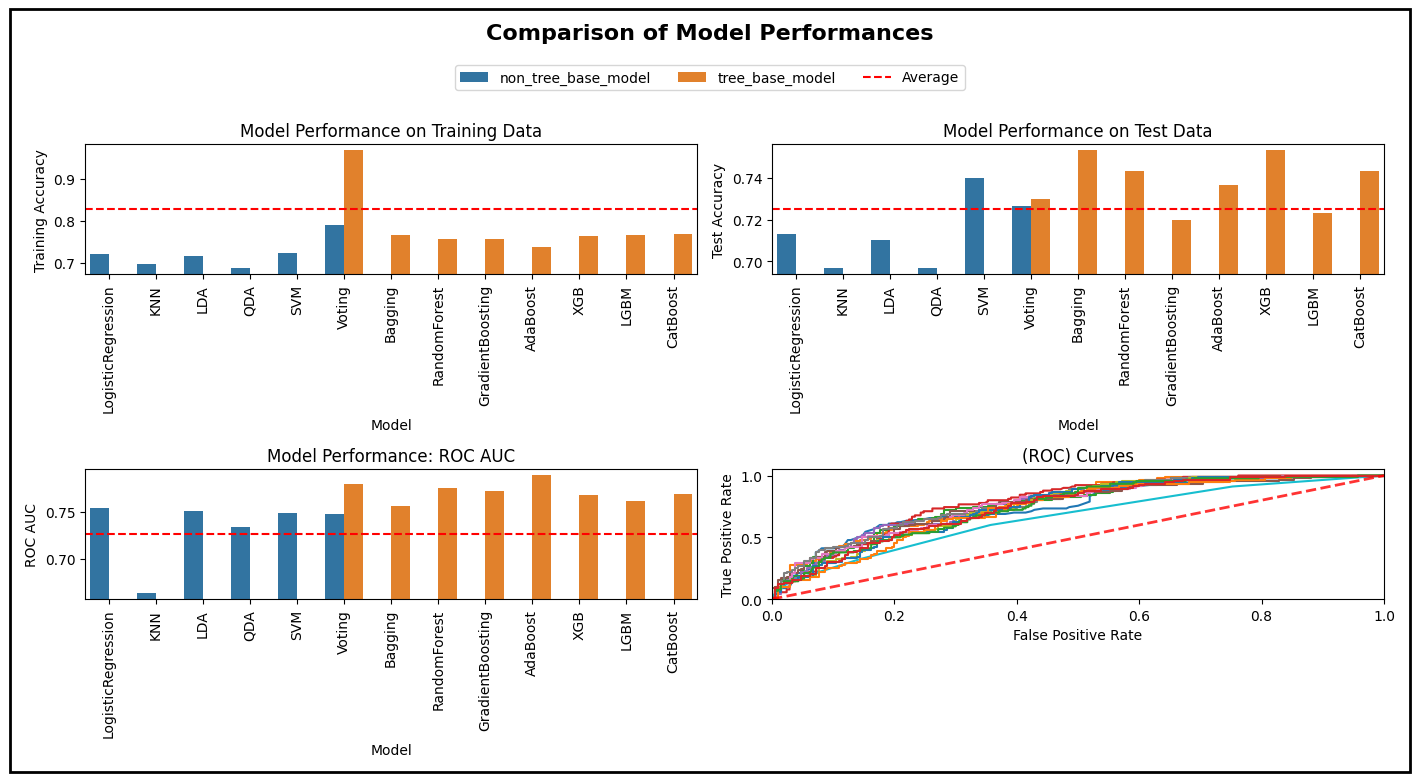

In [17]:
# Create a figure with three subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 7))

# Calculate min and max for 'train' column
train_min = result['train'].min()
train_max = result['train'].max()

# Barplot for training data
sns.barplot(data=result, x='model', y='train', hue='model_type', ax=ax[0][0])
ax[0][0].set_title('Model Performance on Training Data')
ax[0][0].set_xlabel('Model')
ax[0][0].set_ylabel('Training Accuracy')
ax[0][0].set_ylim(train_min - 0.05 * (train_max - train_min), train_max + 0.05 * (train_max - train_min))
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)

# Calculate the average of the min and max for 'train' column and add a horizontal line
train_avg = (train_min + train_max) / 2
ax[0][0].axhline(train_avg, color='red', linestyle='--', label='Average')
ax[0][0].get_legend().remove()


# Calculate min and max for 'test' column
test_min = result['test'].min()
test_max = result['test'].max()

# Barplot for test data
sns.barplot(data=result, x='model', y='test', hue='model_type', ax=ax[0][1])
ax[0][1].set_title('Model Performance on Test Data')
ax[0][1].set_xlabel('Model')
ax[0][1].set_ylabel('Test Accuracy')
ax[0][1].set_ylim(test_min - 0.05 * (test_max - test_min), test_max + 0.05 * (test_max - test_min))
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)

# Calculate the average of the min and max for 'train' column and add a horizontal line
test_avg = (test_min + test_max) / 2
ax[0][1].axhline(test_avg, color='red', linestyle='--', label=f'Average: {test_avg:.2f}')
ax[0][1].get_legend().remove()

# Calculate min and max for 'ROC_AUC' column
roc_auc_min = result['ROC_AUC'].min()
roc_auc_max = result['ROC_AUC'].max()

# Barplot for ROC_AUC data
sns.barplot(data=result, x='model', y='ROC_AUC', hue='model_type', ax=ax[1][0])
ax[1][0].set_title('Model Performance: ROC AUC')
ax[1][0].set_xlabel('Model')
ax[1][0].set_ylabel('ROC AUC')
ax[1][0].set_ylim(roc_auc_min - 0.05 * (roc_auc_max - roc_auc_min), roc_auc_max + 0.05 * (roc_auc_max - roc_auc_min))
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)

# Calculate the average of the min and max for 'train' column and add a horizontal line
roc_auc_avg = (roc_auc_min + roc_auc_max) / 2
ax[1][0].axhline(roc_auc_avg, color='red', linestyle='--', label=f'Average: {roc_auc_avg:.2f}')
ax[1][0].get_legend().remove()

# Create a single legend for the entire figure
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(result['model_type'].unique())+1, bbox_to_anchor=(0.5, 1.02))


# Plot all ROC curves in the bottom right subplot
for model_name in fpr_dict.keys():
    ax[1][1].plot(fpr_dict[model_name], tpr_dict[model_name], label=f'{model_name} (AUC = {roc_auc_dict[model_name]:.2f})')

for model_name in non_fpr_dict.keys():
    ax[1][1].plot(non_fpr_dict[model_name], non_tpr_dict[model_name], label=f'{model_name} (AUC = {non_roc_auc_dict[model_name]:.2f})')

# Plot ROC curve for a random classifier (diagonal line) in the bottom right subplot
ax[1][1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Customize the bottom right subplot
ax[1][1].set_xlim([0.0, 1.0])
ax[1][1].set_ylim([0.0, 1.05])
ax[1][1].set_xlabel('False Positive Rate')
ax[1][1].set_ylabel('True Positive Rate')
ax[1][1].set_title('(ROC) Curves')


# Add a figure title
fig.suptitle('Comparison of Model Performances', fontsize=16, y=1.07, fontweight = "bold")

# Add a rectangle around the entire figure
rect = plt.Rectangle(
    (0.00, 0.0), 1, 1.09, fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])
# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
fig.savefig(r'.\data\model_performance.png', bbox_inches="tight")

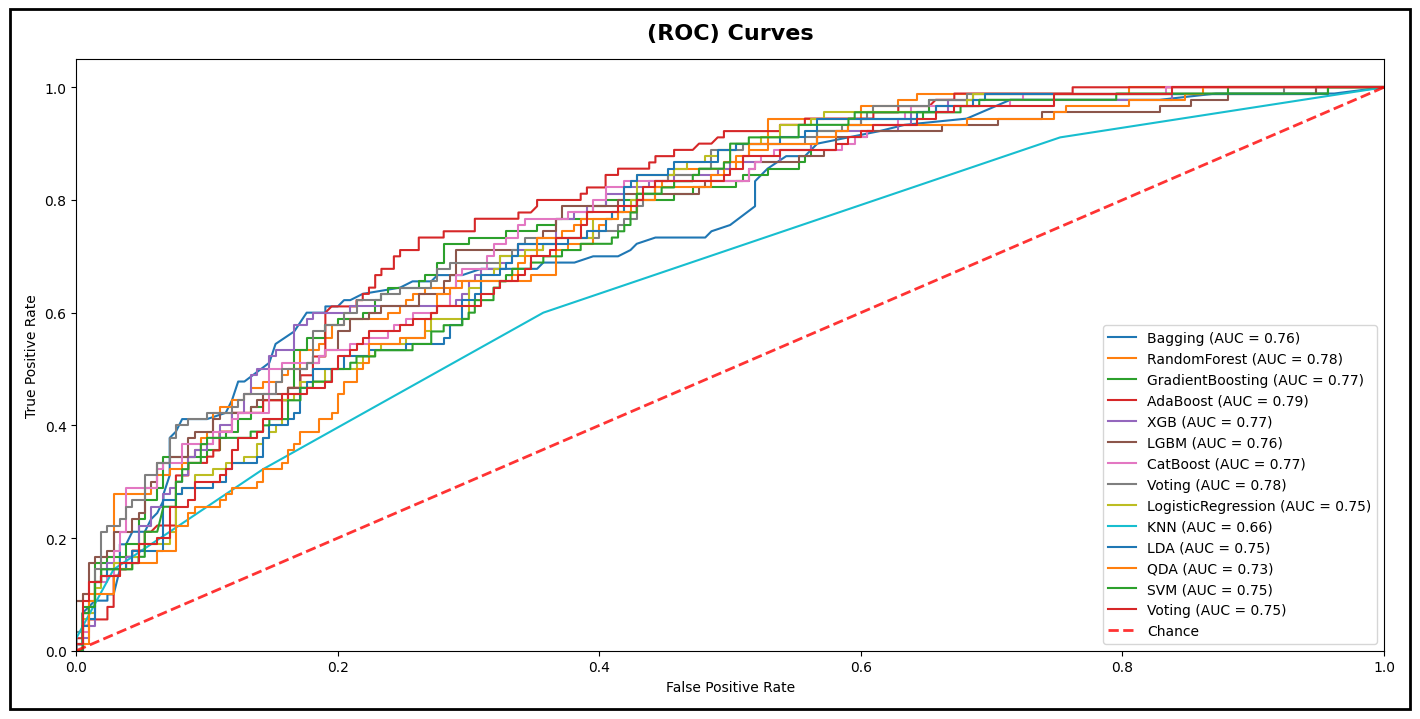

In [18]:
# Plot all ROC curves
fig = plt.figure(figsize=(14, 7))
for model_name in fpr_dict.keys():
    plt.plot(fpr_dict[model_name], tpr_dict[model_name], label=f'{model_name} (AUC = {roc_auc_dict[model_name]:.2f})')

for model_name in non_fpr_dict.keys():
    plt.plot(non_fpr_dict[model_name], non_tpr_dict[model_name], label=f'{model_name} (AUC = {non_roc_auc_dict[model_name]:.2f})')

# Plot ROC curve for a random classifier (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curves', fontsize=16, y=1.02, fontweight = "bold")
plt.legend(loc="lower right")

# Add a rectangle around the entire figure
rect = plt.Rectangle(
    (0.00, 0.0), 1, 1, fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()
fig.savefig(r'.\data\ROC_AUC.png', bbox_inches="tight")